# Include libraries

In [ ]:
# Gensim
import gensim

from gensim.utils import simple_preprocess

#from gensim.test.utils import common_corpus, common_dictionary



# Plotting tools


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#import json files
import json

#For stopword and stemming
import nltk
from nltk.corpus import stopwords

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from gensim.summarization import summarize
#save current path to a variable


## Read data_clean.csv (3811) columns 'filename', 'text' if text length > =100 down to 3606

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import os.path
mypath = os.path.abspath(os.path.dirname("data_clean.csv"))
filepath = os.path.join(mypath, "data_clean.csv")

data = pd.read_csv(filepath)

In [2]:
# Get the stories that are more than 100 words
li =[]
n = len(data)
for i in range(n):
    if len(data["text"][i].split())  <= 100:
        continue
    else:
        li.append(list(data.iloc[i][1:3]))
df = pd.DataFrame(li, columns=['filename', 'text'])

## Remove punctuation from data['text']  and stemming each words and keep the data frame

In [3]:
# Remove punctuation and stemming the text
# spacy for lemmatization
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

data_stem = []
#remove punctuation and stemming and no stop words
for line in df['text']:
    punc_free = "".join(ch for ch in line if ch not in string.punctuation)
    stem = " ".join(wd.lemma_ for wd in nlp(punc_free) if wd.pos_ in ['NOUN', 'VERB']) 
    #stem = " ".join(wd.lemma_ for wd in nlp(punc_free) if wd.pos_ in ['NOUN', 'VERB']) 
    #normalized = " ".join([wd for wd in stem.split() if wd not in stop])
    #res.append(normalized)
    data_stem.append(stem)

In [4]:
df = pd.DataFrame(list(zip(data['filename'], data_stem)), columns=['filename', 'text'])

## Form a vector of words in the whole ducument

In [5]:
def count_words(data):
    res = []
    for line in data:
        for wd in line.split():
            res.append(wd)
    return res
            

In [65]:
# Here is a list of customized stop words
stop_word1 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o','p','q','r','s','t','u','v','w','x','y','z']
stop_word2 = ["an", "at", "as", "of", "on", "be", "to", "so", "in", 'do', 'no', 'um', 'if', 'or', 'oh','up', 
         'hi', 'uh', 'ha','eh', 'iu', 'bs', 'dh', 'ah', 'ok']
stop_word3 = ['would', 'will', 'should', 'shall', 'can', 'could', 'must', '-PRON-', 'the',
        'this', 'these', 'that', 'those', 'here', 'there', 'where', 'what', 'which', 'why', 'when','how', 'while',
        'until', 'after', 'since', 'because', 'though', 'whenever','somehow', 'who', 'anyhow'
         'some', 'something', 'any', 'anything', 'thing', 'every', 'all', 'else', 'either', 'somewhere',
        'everything', 'other', 'everyone', 'each', 'another', 'someone', 'anyone', 'anybody', 'nobody', 'everywhere',
        'much', 'more']

stop_word4 = ['even', 'ever', 'never', 'then', 'just', 'again', 'now', 'still', 'very', 'anyway', 'anyways', 'always', 
         'actually',
        'off', 'way', 'next', 'too', 'also', 'only', 'but', 'and', 'really', 'about', 'for', 'with', 'out', 'once',
        'both', 'almost', 'finally', 'during', 'soon', 'yet', 'completely', 'without', 'along', 'often', 'by', 'off'
        'around', 'from', 'before', 'maybe', 'already', 'usually', 'eventually', 'till', 'instead', 'recently', 
        'early', 'into', 'away', 'around', 'today', 'surprisingly']

stop_word5 = ['friend', 'teacher', 'class']
#include spacy's stop words
stop_spacy = list(nlp.Defaults.stop_words)
stop = stop_spacy + stop_word1 + stop_word2 + stop_word3 + stop_word4 + stop_word5

stop = list(set(stop))
data_nostop = []
for line in data_stem:
    normalized = " ".join([wd for wd in line.split() if wd not in stop])
    data_nostop.append(normalized)


In [66]:
#word frequency after stemming and removing punctuation and standard stop words
data_afterstop = count_words(data_nostop)
word_count = pd.Series(data_afterstop).value_counts()[:20]
#word_count.plot(kind="bar")

In [67]:
# Check top 20 words how many document contains them
#wc_afterstop[1:20].index # A list of frequenct words
wordmap = {}
for wd in word_count.index:
    wordmap[wd] = 0
for line in data_nostop:
    for wd_key in wordmap.keys():
        if wd_key in line.split():
            wordmap[wd_key] += 1


In [68]:
wordfreq = tuple(word_count)
docfreq = []
for w in list(word_count.index):
    docfreq.append(wordmap[w])
docfreq = tuple(docfreq)


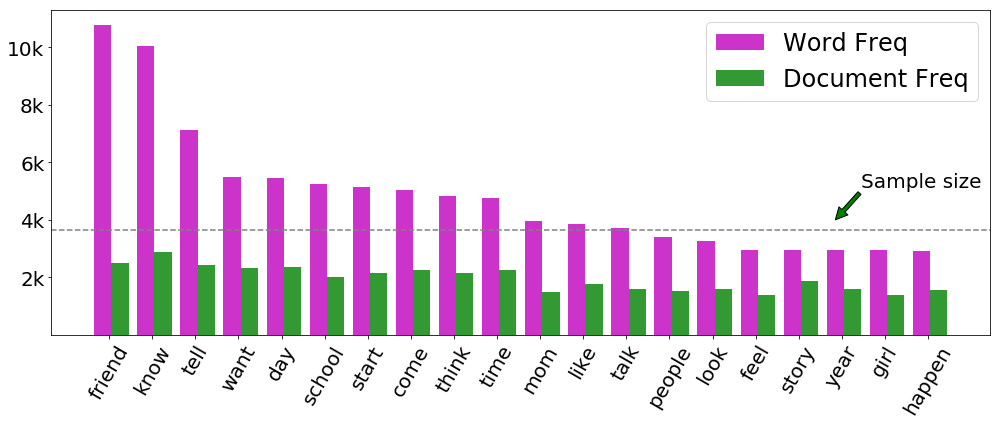

In [73]:
#Plot frequency bar plot
#note: this frequency plot is plotted without stop_word5
#Run from the beginning to get a plot after removing all stop words
import matplotlib.pyplot as plt
%matplotlib inline

xnames = tuple(word_count.index)
n = len(wordfreq)
# create plot
fig, ax = plt.subplots(figsize=(14, 6))
index = np.arange(n)
bar_width = .4
opacity = 0.8
 
rects1 = plt.bar(index, wordfreq, bar_width,
alpha=opacity,
color='m',
label='Word Freq')
 
rects2 = plt.bar(index + bar_width, docfreq, bar_width,
alpha=opacity,
color='g',
label='Document Freq')
 
plt.ylabel('')
plt.title('')
plt.title('')
plt.xticks(index+.15, xnames)
plt.yticks((2000, 4000, 6000, 8000, 10000), ('2k', '4k', '6k', '8k', '10k'))
plt.legend(prop={'size': 24})

plt.tick_params(axis = 'x', labelsize=20, labelrotation= 60,)
plt.tick_params(axis = 'y', labelsize=20)
plt.axhline(y=3650, color="gray", linestyle = "--")
ax.annotate('Sample size', ha = 'center', va = 'bottom', xytext = (19, 5000), xy = (17, 4000), 
            arrowprops = { 'facecolor' : 'green', 'shrink' : 0 }, fontsize = 20)

plt.tight_layout()
plt.savefig('frequency.png', dpi=300, bbox_inches='tight')


## Each document is a list of string vector

In [11]:
#Tokenize words in eah story, story is still a list, result is a list of list of string
def Tokenize(doc):
    res = []
    for line in doc:
        res.append(line.split())
    return res

In [12]:
#Generate dictionary and corpus for LDA model
import gensim.corpora as corpora

data_tokenized = Tokenize(data_nostop)
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_tokenized)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
tf_matrix = [dictionary.doc2bow(doc) for doc in data_tokenized]

In [13]:
# Generate tf-idf matrix
from gensim import models
tfidf = models.TfidfModel(tf_matrix, smartirs='ltn')  #first l-logrithm, first n-natural last n- not normalization

In [14]:
# before training/inference: for repetition
SOME_FIXED_SEED = 897

Num_Topics = 10
#corpus = tf_matrix
corpus = tfidf[tf_matrix]

#Simple processor model
%time ldamodel = models.LdaModel(corpus=corpus, num_topics = Num_Topics, id2word=dictionary, passes=20,alpha='auto',\
            update_every=0, per_word_topics=True, minimum_probability=0.2, random_state=np.random.seed(SOME_FIXED_SEED))


CPU times: user 1min 6s, sys: 195 ms, total: 1min 6s
Wall time: 1min


In [15]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)


/Users/jinny/anaconda3/envs/insight/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
# If you want to save the above plot, excute these code
#p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
#pyLDAvis.save_html(p, '../Desktop/lda.html')

In [16]:
#Look at the terms appearing more in each topic 
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [62]:
topic_summaries = []
num_topics = 10
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print("\n")
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(ldamodel,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

term                 frequency



Topic 0 |---------------------

girl                 0.004
school               0.003
rumor                0.003
people               0.003
grade                0.003
start                0.003
stuff                0.003
cry                  0.003
play                 0.003
boy                  0.003


Topic 1 |---------------------

grade                0.004
stop                 0.004
feel                 0.004
stuff                0.004
like                 0.004
rumor                0.004
talk                 0.003
people               0.003
girl                 0.003
play                 0.003


Topic 2 |---------------------

group                0.006
girl                 0.006
ask                  0.005
crush                0.005
like                 0.005
talk                 0.005
grade                0.004
recess               0.004
school               0.004
use                  0.004


Topic 3 |---------------------

dad                  0

## Add a column of topics into original data frame --> filename, text, topics
1) ldamodel.get_document_topics(argument) where arg is a bag of words created by dictionary.doc2bow(a vector of string)  
2) get_document_topics return a list of tuples of (topic#, probability), we need to get the topic having largest probability  

In [18]:
li = []
for doc_num, line in enumerate(data_tokenized):
    bow = dictionary.doc2bow(line)
    topic_assignment = ldamodel.get_document_topics(bow)
    n = len(topic_assignment)
    prob = []
    for i in range(n):
        prob.append(topic_assignment[i][1])
    li.append(topic_assignment[np.argmax(prob)][0])
df['topics'] = li

## save topics into a files

In [19]:
#Already saved
#df.to_csv('data_topics.csv', index=False)
df.groupby(["topics"]).count()

,filename,text
topics,,
0,223,223
1,239,239
2,490,490
3,299,299
4,205,205
5,1052,1052
6,258,258
7,464,464
8,186,186


# Generate a series of models with different #topic compare conherence and perpelexity score. 

In [20]:
SOME_FIXED_SEED = 123
#build collection of models 
Num_topics = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 30]
#corpus = tf_matrix
corpus = tfidf[tf_matrix]
models_tfidf = []

#Define a function to compute models, input can be TF or TFIDF (with variation of TFIDF)
def Find_models(corpus, Num_topics, SOME_FIXED_SEED):
    res = []
    for i in Num_topics:
        ldamodel = models.LdaModel(corpus=corpus, num_topics = i, id2word=dictionary, passes=20, alpha='auto', 
                   update_every=0, per_word_topics=True, minimum_probability=0.2, random_state=np.random.seed(SOME_FIXED_SEED))
        res.append(ldamodel)
    return res


In [ ]:
# This is very expensive to run
%time ldamodels = Find_models(corpus, Num_topics)

In [25]:
#Read in all lda models saved
ldamodels = []
for i in Num_topics:
    if i != 30:
        name = "ldamodels/model"+str(i)+".gensim"
        ldamodels.append(models.LdaModel.load(name))
len(ldamodels)

23

In [39]:
#compute coherence score
from gensim.models import CoherenceModel

def Compute_coherence(ldamodels, mode):
    res = []
    for m in ldamodels:
        coherence_model_lda = CoherenceModel(model=m, texts=data_tokenized, dictionary=dictionary, coherence= mode, window_size = 100)
        res.append(coherence_model_lda.get_coherence())
    return res
                   

#Option of modes are "c_v", "u_mass", ...
coherence_cv = Compute_coherence(ldamodels, 'c_v')

[0.31957928656464035,
 0.3367984926668662,
 0.34119612599946825,
 0.3415099142446539,
 0.338946338210934,
 0.3406104347061843,
 0.33446044524025487,
 0.3473255740550073,
 0.31710541962750377,
 0.32128216466271114,
 0.3118431226219304,
 0.3145652461462131,
 0.2989937478118329,
 0.301730590246133,
 0.3011795907832725,
 0.29982478746042174,
 0.2907807024900212,
 0.28838468557431995,
 0.2904454900174407,
 0.29948767241250407,
 0.29450770292301914,
 0.2918710860980636,
 0.28518418403233725]

The following functions save all the lda models into local disk and save 4 types coherence score to local disk

In [ ]:
f = open('coherence_cv.txt', mode = 'w')
for line in coherence_cv:
    f.write(str(line))
f.close()
#pd.DataFrame(coherence_tfidf).to_csv("coherence.")

In [ ]:
coherence_umass = Compute_coherence(models, 'u_mass')
print(coherence_umass)
f = open('coherence_umass.txt', mode = 'w')
for line in coherence_umass:
    f.write(str(line))
f.close()

In [ ]:
coherence_cuci = Compute_coherence(models, 'c_uci')
print(coherence_cuci)
f = open('coherence_cuci.txt', mode = 'w')
for line in coherence_cuci:
    f.write(str(line))
f.close()

In [ ]:
coherence_cnpmi = Compute_coherence(models, 'c_npmi')
print(coherence_cnpmi)
f = open('coherence_cnpmi.txt', mode = 'w')
for line in coherence_cnpmi:
    f.write(str(line))
f.close()

In [ ]:
# Models are saved
size = len(models)
for i in size:
    name = "model"+str(i)+".gensim"
    models[i].save(name)

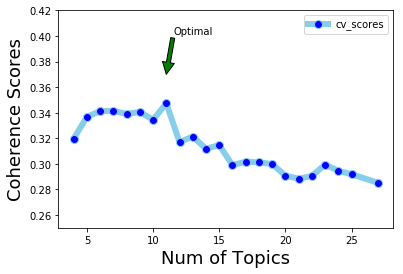

In [64]:
#Plot coherence scores "c_v"
df = pd.DataFrame({'cv_scores': coherence_cv, 'Num of Topics': Num_topics[:23]})
fig, ax = plt.subplots()
ax.plot( 'Num of Topics', 'cv_scores', data=df, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=6)
#ax.plot( 'Num of Topics', 'TF-model', data=df, marker='o', markerfacecolor='purple', markersize=8, color='magenta', linewidth=6)
ax.set_xlabel("Num of Topics", size=18)
ax.set_ylabel("Coherence Scores", size=18)
ax.set_ylim([0.25,0.42])
ax.legend()
ax.annotate('Optimal', ha = 'center', va = 'bottom', xytext = (13, .40), xy = (11, .37), arrowprops = { 'facecolor' : 'green', 'shrink' : 0 })
#plt.show()
plt.savefig('coherence_cv.png', dpi=300, bbox_inches='tight')

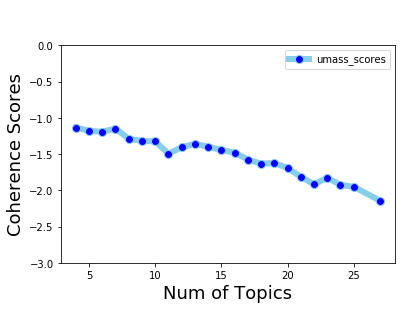

In [56]:
coherence_umass = Compute_coherence(ldamodels, 'u_mass')
#Plot coherence scores
df = pd.DataFrame({'umass_scores': coherence_umass, 'Num of Topics': Num_topics[:23]})
fig, ax = plt.subplots()
ax.plot( 'Num of Topics', 'umass_scores', data=df, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=6)
#ax.plot( 'Num of Topics', 'TF-model', data=df, marker='o', markerfacecolor='purple', markersize=8, color='magenta', linewidth=6)
ax.set_xlabel("Num of Topics", size=18)
ax.set_ylabel("Coherence Scores", size=18)
ax.set_ylim([-3,0])
ax.legend()
#ax.annotate('Optimal', ha = 'center', va = 'bottom', xytext = (13, .40), xy = (11, .37), arrowprops = { 'facecolor' : 'green', 'shrink' : 0 })
plt.show()
#plt.savefig('coherence.png', dpi=300, bbox_inches='tight')

In [ ]:
coherence_cnpmi = Compute_coherence(ldamodels, 'c_npmi')

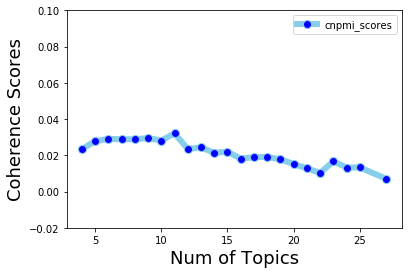

In [60]:
#Plot coherence scores
df = pd.DataFrame({'cnpmi_scores': coherence_cnpmi, 'Num of Topics': Num_topics[:23]})
fig, ax = plt.subplots()
ax.plot( 'Num of Topics', 'cnpmi_scores', data=df, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=6)
#ax.plot( 'Num of Topics', 'TF-model', data=df, marker='o', markerfacecolor='purple', markersize=8, color='magenta', linewidth=6)
ax.set_xlabel("Num of Topics", size=18)
ax.set_ylabel("Coherence Scores", size=18)
ax.set_ylim([-0.02,.1])
ax.legend()
#ax.annotate('Optimal', ha = 'center', va = 'bottom', xytext = (13, .40), xy = (11, .37), arrowprops = { 'facecolor' : 'green', 'shrink' : 0 })
plt.show()
#plt.savefig('coherence.png', dpi=300, bbox_inches='tight')

In [ ]:
# Compute Perplexity: a measure of how good the model is. lower the better.
perplexity_tf = []
corpus = tf_matrix
for m in models_tf:
    perplexity_tf.append(m.log_perplexity(corpus))

corpus = tfidf[tf_matrix]
perplexity_tfidf = []
for m in models_tfidf:
    perplexity_tfidf.append(m.log_perplexity(corpus))

In [ ]:
#Plot perplexity scores
df = pd.DataFrame({'TFIDF-model': perplexity_tfidf, "TF-model": perplexity_tf, 'Num of Topics': Num_Topics})
plt.plot( 'Num of Topics', 'TFIDF-model', data=df, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=6)
plt.plot( 'Num of Topics', 'TF-model', data=df, marker='o', markerfacecolor='purple', markersize=8, color='magenta', linewidth=6)
plt.xlabel("Num of Topics", size=18)
plt.ylabel("Perplexity Scores", size=18)
plt.legend()
plt.ylim(-9, -3)
plt.savefig('perplexity.png', dpi=300, bbox_inches='tight')

In [ ]:
#Manipulate with topics and words:
#.get_topics()  np.array (number of topics * number of words in dictionary)
Num_Word = len(dictionary)
matrix = np.transpose(ldamodel.get_topics())
li = []
for i in range(Num_Word):
    li.append([dictionary[i], np.argmax(matrix[i, :])])
    
df_words = pd.DataFrame(li, columns=['word', 'topic'])

#output number of words associated with each topic
df_words.groupby(['topic']).count()
